In [28]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt

In [29]:
path = "C:/data/SiPM/waveforms/20240402/"
filename_list = glob.glob(path + "Am241_vb_28V_bare_scint*.pkl")
template_file = path + "Am241_vb_28V_bare_scint_x0.0_y0.0.pkl"
ov=28

In [30]:
def parse_position(fname):
    file_parts = fname[:-4].split("_")
    x, y = float(file_parts[-2][1:]), float(file_parts[-1][1:])
    return x,y

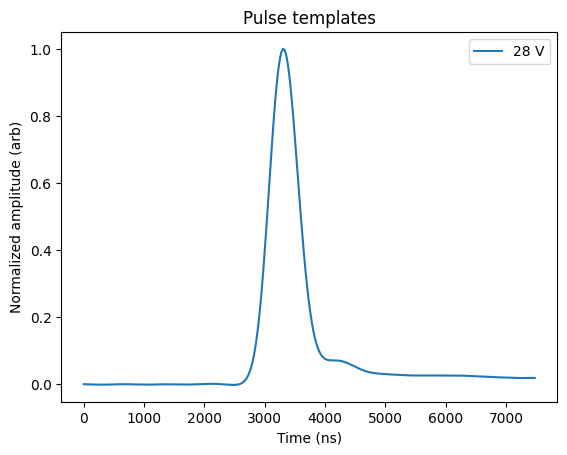

In [31]:
template_dict = {}

plt.figure()

with open(template_file, 'rb') as tf:
    data_dict = pickle.load(tf)
    
nwaveforms = len(data_dict.keys())-1

## make average template
template = np.zeros_like(data_dict['time'])
nwfm = 0
for j in range(nwaveforms):

    cdat = data_dict[j][1]

    template += cdat
    nwfm += 1

template /= nwfm
template -= np.median(template[:100])
template /= np.max(template)

plt.plot(data_dict['time'], template, label="%s V"%str(ov))
plt.xlabel('Time (ns)')
plt.ylabel('Normalized amplitude (arb)')

plt.title("Pulse templates")
plt.legend()
plt.show()

In [35]:
xval_list = []
yval_list = []

for fidx, fname in enumerate(filename_list):

    xpos, ypos = parse_position(fname)

    if xpos not in xval_list:
        xval_list.append(xpos)

    if ypos not in yval_list:
        yval_list.append(ypos)

xval_list, yval_list = sorted(xval_list), sorted(yval_list)

print(xval_list, yval_list)


[-8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0] [-8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


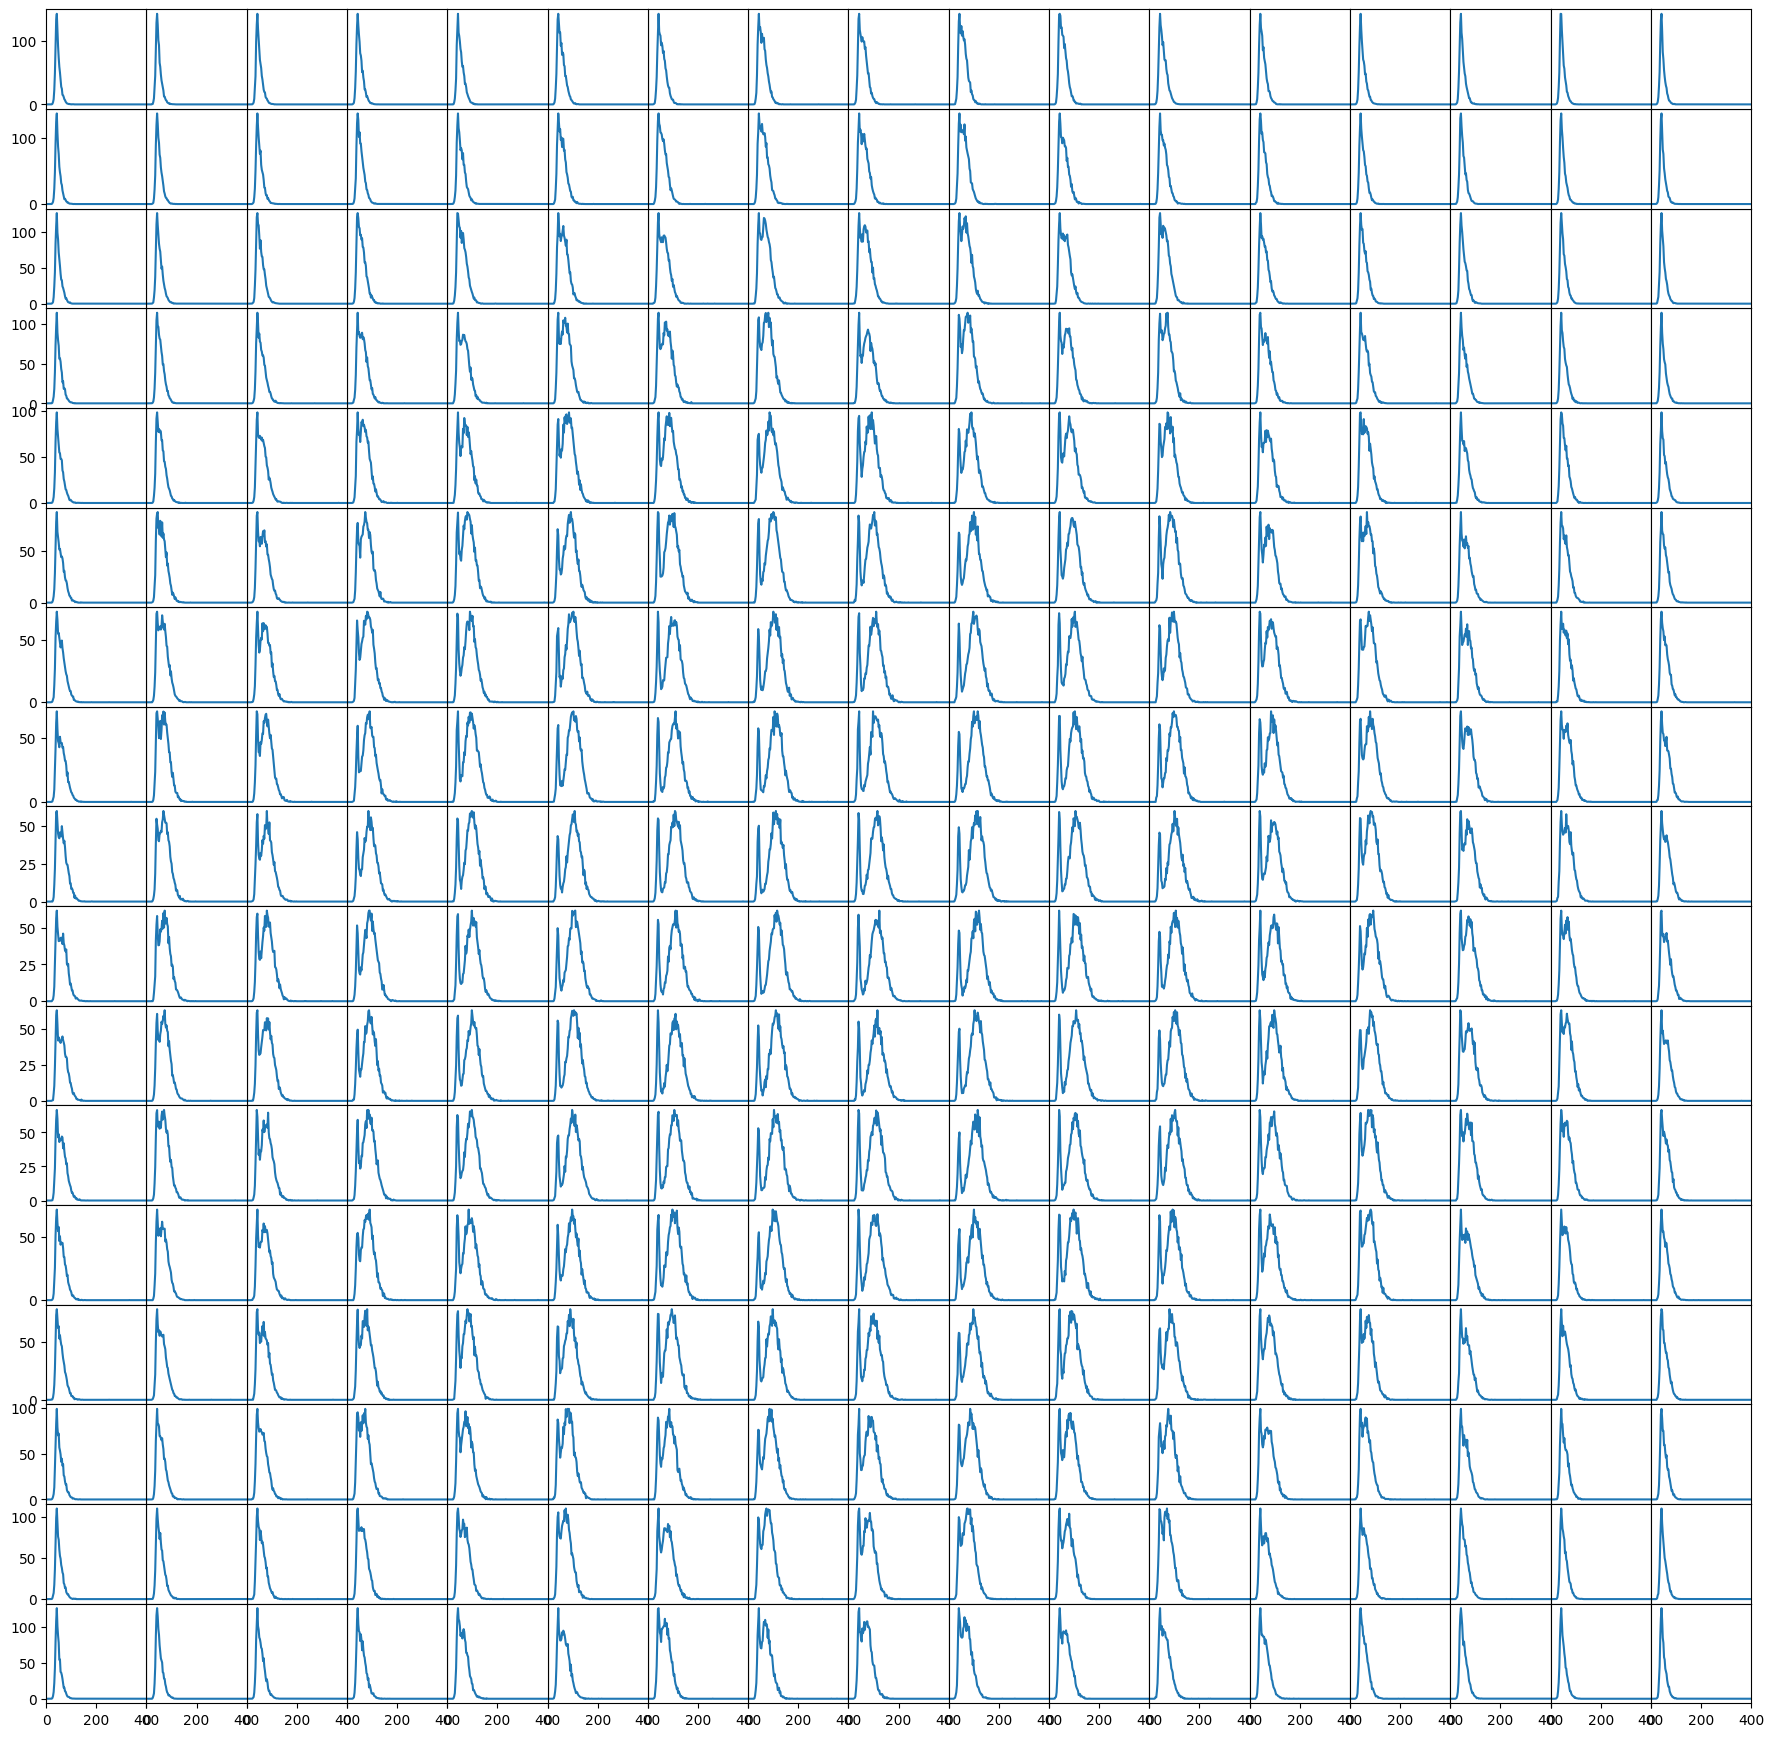

In [38]:
nrows = len(yval_list)
ncols = len(xval_list)

plt.figure(figsize=(22,22))
remake_files = False
for fidx, fname in enumerate(filename_list):

    xpos, ypos = parse_position(fname)

    if(remake_files):

        print("Working on file: ", fname)

        window  = [2500, 4000]

        recon_amps = []
            
        with open(fname, 'rb') as fin:
            data_dict = pickle.load(fin)

        mpts = (data_dict['time']>window[0]) & (data_dict['time']<window[1])

        wfidx = 0
        for k in data_dict.keys():
            if k == 'time': continue

            cdat = data_dict[k][1]
            
            ## baseline subtract
            cdat -= np.median(cdat[:50])

            fit = np.sum( cdat*template ) / np.sum(template**2)

            midx = np.argmax(np.abs(cdat[mpts]))
            max_val = cdat[mpts][midx]
            recon_amps.append( [max_val, fit] )

            wfidx += 1
    
        nwaveforms = wfidx
        recon_amps = np.array(recon_amps)

        np.savez( os.path.join(path, "recon_amps_%.1f_%.1f.npz"%(xpos, ypos)), recon_amps=recon_amps,nwaveforms=nwaveforms)
    
    else:
        data = np.load( os.path.join(path, "recon_amps_%.1f_%.1f.npz"%(xpos, ypos)) )
        recon_amps = data['recon_amps']
        nwaveforms = data['nwaveforms']


    if(fidx ==0 ):
        noise_data = np.load( os.path.join(path, "recon_amps_-8.0_-8.0.npz"%(xpos, ypos)) )
        noise_amps = noise_data['recon_amps']
    

    bins = np.linspace(0,500,200)
    bc = bins[:-1] + np.diff(bins)

    norm = 10 ## time in seconds

    h_max, be = np.histogram( recon_amps[:,0], bins=bins )
    h_fit, be = np.histogram( recon_amps[:,1], bins=bins )

    if('bkg' in str(ov)): 
        continue

    col_idx = xval_list.index(xpos)
    row_idx = yval_list.index(ypos)

    plt.subplot(nrows,ncols, row_idx*ncols + col_idx + 1)
    plt.plot(bc, h_max/norm, label="%s V"%str(ov))
    plt.xlim(0,400)
    if(col_idx > 0):
        plt.gca().set_yticks([])    
    if(row_idx < nrows-1):
        plt.gca().set_xticks([])
    #if(row_idx == len())
    #plt.xlabel("Uncalib. pulse height (mV)")
    #plt.ylabel("Counts/s")
    #plt.title("Max of waveform")

#plt.subplot(1,2,1)
#plt.legend()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()